In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

from Funcoes_gerais import funcoes

root_dir = f"/home/adriano/projeto_mestrado/modules"

tracados_bezier = f'{root_dir}/Annotation/Artificial_lines/tracados_bezier'

img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X'

def bezier(points, precision):
    ts = np.linspace(0, 1, precision)
    B = np.zeros((len(ts), 2), dtype=np.float64)
    n = len(points) - 1
    for idx, t in enumerate(ts):
        for i in range(n+1):
            bin_coef = np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n-i))
            Pin = bin_coef * (1-t)**(n-i) * t**i
            B[idx] += Pin * points[i]

    return B

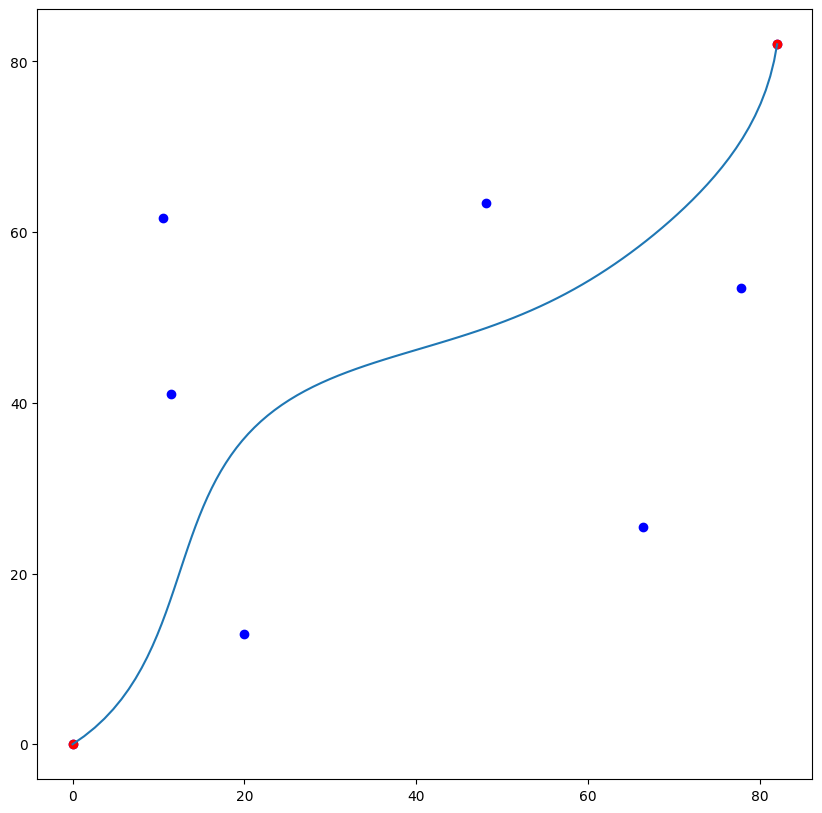

In [2]:
# Sorteando curvas aleatórias
ps = np.array((0, 0)) # ponto inicial

num = np.random.randint(80,250, size=(1))
pe = np.array((num[0], num[0])) # ponto final

#Original do Matheus
#pe = np.array((100, 100)) # ponto final
dx = pe[0]-ps[0]
dy = pe[1]-ps[1]
normal_se = np.array((-dy, dx)) #ou (dy, -dx) --> vetor normal à (pe-ps)
max_vd = 0.4 # distancia máxima em que os pontos de controle serão sorteados (usar entre 0 e 1)
n_points = 6 # numero de pontos de controle entre pe e ps 

control_points = []
hds = np.linspace(0.2, 0.8, n_points) # faz com que os pontos de controle sejam equidistantes em relação à (pe-ps)
for i in range(n_points):
    # control_point = (pe-ps) * np.random.uniform(low=0.2, high=0.8)
    control_point = (pe-ps) * hds[i] # setar as distancias horizontais dessa maneira deixa um aspecto mais natural
    control_point += (normal_se * np.random.uniform(low=-1, high=1) * max_vd)
    control_points.append(control_point)

control_points.insert(0, ps)
control_points.append(pe)
curve = bezier(control_points, precision=100)
plt.figure(figsize=(10, 10))
xs, ys = list(zip(*control_points))
plt.scatter(xs, ys, color="blue")
plt.scatter(ps[0], ps[1], color="red")
plt.scatter(pe[0], pe[1], color="red")
xs, ys = list(zip(*curve))
plt.plot(xs, ys)

In [3]:

arquivo = f'{tracados_bezier}/{img_especifica}_savedata_1.json'

# arquivo = f'{root_dir}/Vetores_Extraidos_json/teste{imag}.json'
funcoes.gravar_array_arquivo(curve,arquivo)

FileNotFoundError: [Errno 2] No such file or directory: '/home/adriano/projeto_mestrado/modules/Annotation/Artificial_lines/tracados_bezier/Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 3-20X_savedata_1.json'